In [1]:
#%%
# Import required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.FokkerPlanckModel import FokkerPlanckModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn_potential import FCN_Potential
from models.fcn import FCN
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl, generate_grid, extract_vector_field, fisher_divergence
from plot_utils import plot_log_energy

In [2]:
def calculate_wasserstein(batch1, batch2):
    import ot
    n_batch = batch1.shape[0]
    cost_matrix = torch.cdist(batch1, batch2) ** 2
    weights = torch.ones(n_batch)/n_batch
    wasserstein = float(ot.emd2(weights, weights, cost_matrix, numItermax=int(1e6)))
    return wasserstein

def visualise_samples(samples, title='samples', force_range=False):
    samples_np =  samples.cpu().numpy()
    plt.figure(figsize=(10,10))
    image = plt.scatter(samples_np[:,0],samples_np[:,1])
    if force_range:
        plt.ylim(-1.5,1.5)
        plt.xlim(-1.5,1.5)
    plt.gca().set_aspect('equal')
    plt.savefig('figures/'+title, dpi=300)

def print_sampling_parameters(config):
    sampling = config.sampling
    model = config.model
    print('predictor:', sampling.predictor)
    print('num_time_steps', model.num_scales)
    print('corrector:', sampling.corrector)
    print('snr:',  sampling.snr)
    print('n_steps_each:', sampling.n_steps_each)
    print('probability_flow:', sampling.probability_flow)
    print('noise_removal:', sampling.noise_removal)

def get_sampling_config(config, snr=0.075, predictor='reverse_diffusion', corrector = 'none', 
                n_steps_each=1, probability_flow=False, num_scales=1000):
    
    sampling = config.sampling
    sampling.corrector = 'pc'
    sampling.predictor =  predictor
    sampling.corrector = corrector
    sampling.n_steps_each = n_steps_each
    sampling.noise_removal = True
    sampling.probability_flow = probability_flow
    sampling.snr = snr

    model = config.model
    model.num_scales = num_scales

    return config

def sample(ckpt_path, sampling_config):
    from sampling.unconditional import get_sampling_fn
    pl_module = FokkerPlanckModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 1000   
    sde = pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

# Tests

In [3]:
import torch.nn as nn
import pytorch_lightning as pl
class GTModel(pl.LightningModule):
    def __init__(self, gt_fn, energy_fn=None):
        super().__init__()
        self.gt_fn = gt_fn
        self.energy_fn = energy_fn

    def forward(self, x, t):
        return self.gt_fn(x, t)

    def energy(self, x, t):
        if self.energy_fn is None:
            print('No energy function')
            return None
        return self.energy_fn(x,t)
        


In [6]:
from configs.jan.gaussian.fokker_planck_gauss import get_config
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from sampling.unconditional import get_sampling_fn
config = get_config()
config.data.mixtures=10
config.data.std = 0.05
data_m = SyntheticDataModule(config)
data_m.setup()
num_samples = 500  
dataset = data_m.dataset
sde = dataset.sde

sampling_eps = 1e-5
sampling_shape = [num_samples] +  config.data.shape
gamma = 1
gt_score_fn = lambda x,t: gamma * dataset.ground_truth_score(x,t)
gt_energy_fn = lambda x,t: torch.exp(dataset.log_prob(x,t))
score_model = GTModel(gt_score_fn, gt_energy_fn)


In [42]:
config = get_sampling_config(config, snr=0.01, predictor='none', corrector = 'langevin', 
                n_steps_each=1, probability_flow=False, num_scales=1000)

data_m = SyntheticDataModule(config)
data_m.setup()
num_samples = 1000  
dataset = data_m.dataset
sde = dataset.sde

sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)


In [43]:
samples, _ = sampling_fn(score_model)

100%|██████████| 1000/1000 [00:05<00:00, 196.88it/s]


predictor: none
num_time_steps 1000
corrector: langevin
snr: 0.01
n_steps_each: 1
probability_flow: False
noise_removal: True


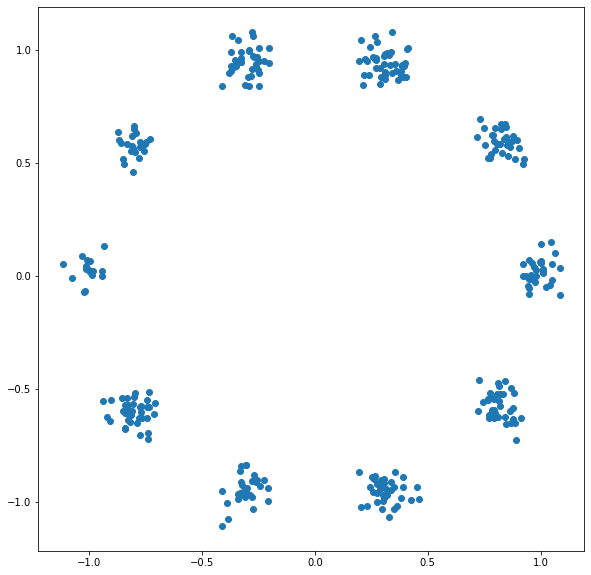

In [44]:
visualise_samples(samples)
print_sampling_parameters(config)

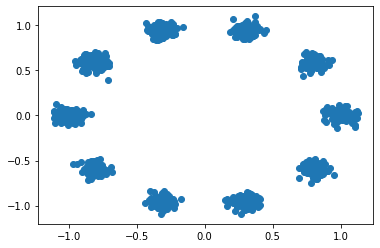

In [7]:
plt.scatter(dataset.data[:1000,0], dataset.data[:1000,1])